In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Домашнее задание №3

Решенный ноутбук нужно загрузить в [форму](http://bit.ly/dafe_hw)  
Дедлайн: __22.05.2019__

## Загрузка данных (5%)

In [2]:
lfw_people = datasets.fetch_lfw_people(
    min_faces_per_person=50, 
    resize=0.4)

Выведите:
- кол-во объектов
- Кол-во признаков
- кол-во классов
- посмотрите, сколько изображений соответствет каждому классу
- Отрисуйте изображения для случайных семплов с подписями имен класса 

кол-во объектов 1560
Кол-во признаков 1850
кол-во классов 12
{0: 77, 1: 236, 2: 121, 3: 530, 4: 109, 5: 71, 6: 52, 7: 55, 8: 53, 9: 60, 10: 52, 11: 144}


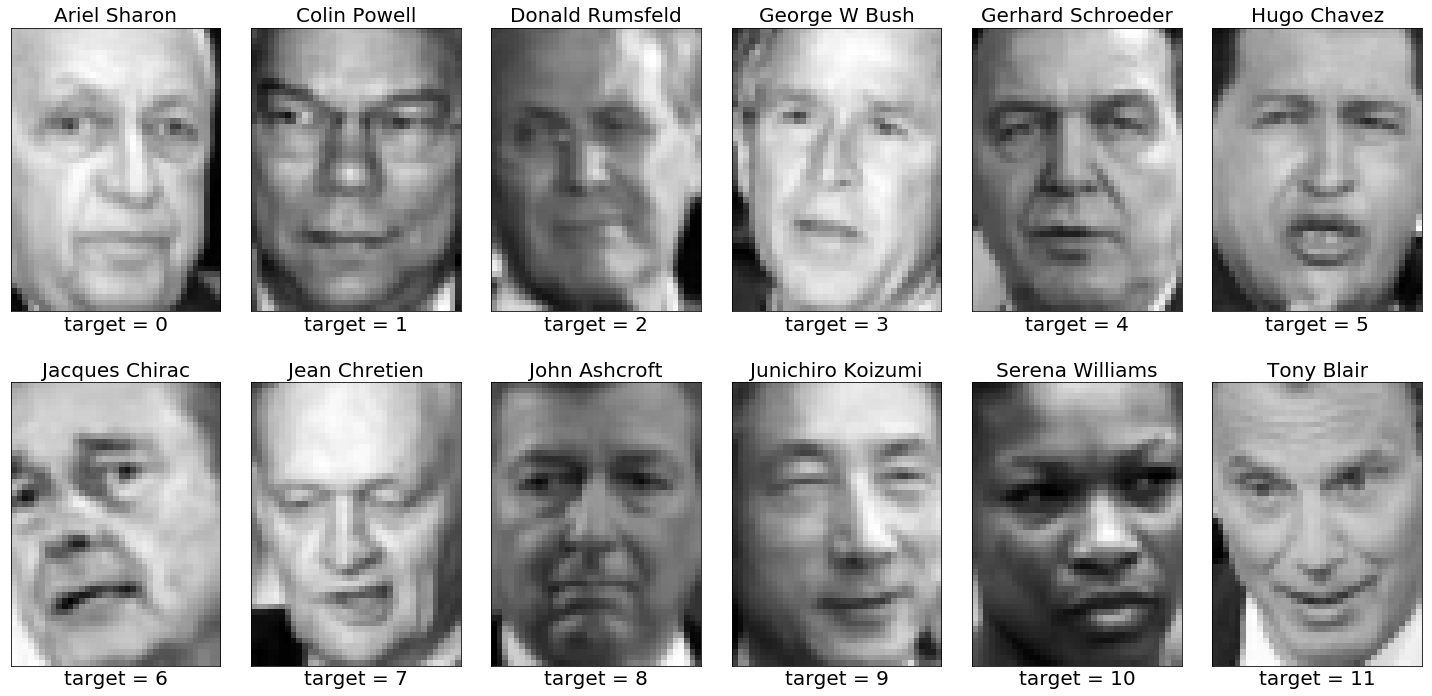

In [3]:
# Ваш код здесь
print('кол-во объектов', lfw_people.data.shape[0])
print('Кол-во признаков', lfw_people.data.shape[1])
num_classes = len(set(lfw_people.target))
print('кол-во классов', num_classes)
unique, counts = np.unique(lfw_people.target, return_counts=True)
print(dict(zip(unique, counts)))

pic_to_idx = {idx:i for i, idx in enumerate(lfw_people.target)}

fig, ax = plt.subplots(nrows = 2, ncols = 6, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(num_classes):
    ax[i].imshow(lfw_people.images[pic_to_idx.get(i)], cmap='gray')
    ax[i].set_title(lfw_people.target_names[i], fontsize=20)
    ax[i].set_xlabel('target = {}'.format(i), fontsize=20)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## Пора учить нейронки! (5%) 

In [4]:
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout 
from keras.utils import np_utils
from keras.optimizers import Adam

Using TensorFlow backend.


In [5]:
# Конечно мы сначала должны нормировать и центрировать данные: 
mean, std = lfw_people.data.mean(), lfw_people.data.std()
x = (lfw_people.data - mean) / std
y = lfw_people.target

# используйте lfw_people.target и lfw_people.images

In [6]:
def indices_to_one_hot(data, nb_classes):
    """one-hot-encoding"""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

y_ohe = indices_to_one_hot(y, num_classes)

In [139]:
# Разделим данные на трейн/валидацию/тест: 
x_train, x_test, y_train_cat, y_test_cat = train_test_split(x, y_ohe, 
                                                            train_size=0.6, 
                                                            test_size=0.4, 
                                                            random_state=42)
x_val, x_test, y_val_cat, y_test_cat = train_test_split(x_test, y_test_cat, 
                                                        train_size=0.5, 
                                                        test_size=0.5, 
                                                        random_state=42)

# Cделайте one-hot-encoding для целевой переменной

## Fully connected neural network (20%)
Создадим нашу первую модель, будем использовать полносвязную нейронную сеть 
- Первый слой (входной): 64 нейрона, функция активации ReLU
- Скрытый слой: 32 нейрона, функция активации ReLU
- Чтобы наша сеть не переобучалась, после каждого полно-связного используйте слой Dropout с параметром rate = 0.4
- Выходной слой: на ваше усмотрение :) 

Будем обучать с помощью Adam на 100 эпохах,  размер сэмпла для минибатча: 10

Учимся на train, валидируем на val

In [82]:
input_shape = x_test[0, :].shape
epochs = 100
batch_size = 50
steps = 300

### Generator (threads)

In [83]:
import threading

class threadsafe_iter:
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)
        
def threadsafe_generator(f):
    """
    A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

In [117]:
@threadsafe_generator
def make_image_gen_cat(in_df, batch_size=batch_size):
    out_map = []
    out_class = []
    x, y = in_df
    indexes = np.random.randint(0, x.shape[0], x.shape[0])
    while True:
        for index in indexes:
            out_map += [x[index]]
            out_class += [y[index]]
            if len(out_map) >= batch_size:
                out_map = np.array(out_map)
                out_class = np.array(out_class)
                out_map = out_map.reshape(out_map.shape[0], input_shape[0])
                yield np.stack(out_map, 0), out_class
                out_map = []
                out_class = []

In [118]:
valid_x, valid_y = next(make_image_gen_cat((x_test, y_test_cat)))
print(valid_x.shape, valid_y.shape)

(50, 1850) (50, 12)


In [119]:
model = Sequential()
model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = Adam()

In [120]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                118464    
_________________________________________________________________
activation_19 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_20 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 12)                396       
__________

In [121]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path='easy_weights.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=7)



callbacks_list = [checkpoint, reduceLROnPlat, early]

In [122]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
gen_train_cat = make_image_gen_cat((x_train, y_train_cat))
gen_valid_cat = make_image_gen_cat((x_val, y_val_cat))

history = model.fit_generator(gen_train_cat,
                              steps_per_epoch=steps,
                              validation_data=gen_valid_cat,
                              validation_steps=100,
                              epochs=epochs,
                              callbacks=callbacks_list,
                              workers=16,
                              verbose=1)

Epoch 1/100
300/300 [==============================] - 3s 11ms/step - loss: 1.5147 - acc: 0.5028 - val_loss: 1.1118 - val_acc: 0.6662

Epoch 00001: val_acc improved from -inf to 0.66620, saving model to easy_weights.h5
Epoch 2/100
300/300 [==============================] - 2s 6ms/step - loss: 0.7193 - acc: 0.7581 - val_loss: 1.1881 - val_acc: 0.7308

Epoch 00002: val_acc improved from 0.66620 to 0.73080, saving model to easy_weights.h5
Epoch 3/100
300/300 [==============================] - 3s 10ms/step - loss: 0.4675 - acc: 0.8415 - val_loss: 1.3114 - val_acc: 0.7394

Epoch 00003: val_acc improved from 0.73080 to 0.73940, saving model to easy_weights.h5
Epoch 4/100
300/300 [==============================] - 3s 11ms/step - loss: 0.3597 - acc: 0.8807 - val_loss: 1.4695 - val_acc: 0.7584

Epoch 00004: val_acc improved from 0.73940 to 0.75840, saving model to easy_weights.h5
Epoch 5/100
300/300 [==============================] - 3s 9ms/step - loss: 0.3079 - acc: 0.8982 - val_loss: 1.3416 -

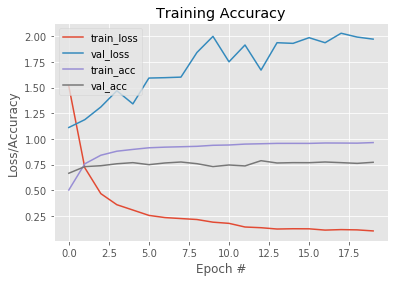

In [124]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

Постройте confusion_matrix (используйте sklearn) на тестовой выборке (test) и посчитайте долю правильных ответов(test)

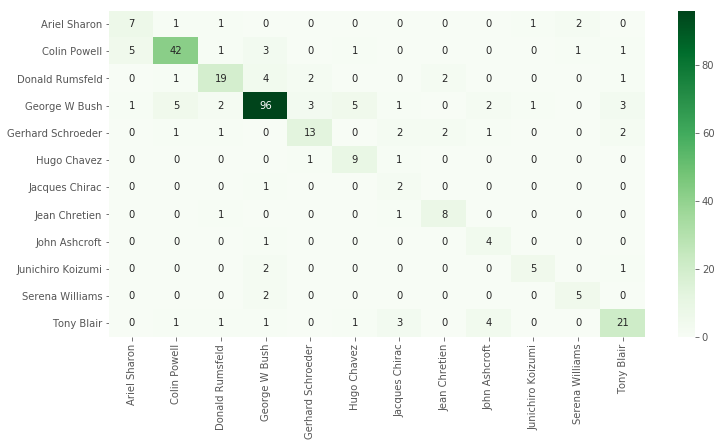

In [125]:
y_pred = model.predict(x_test).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
confusionmatrix = confusion_matrix(y_pred, y_true)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Оцените, кого с кем вы чаще всего путаете? Почему одних людей наша сеть путает с другими чаще?

__Ответ:__

Вспомним, что в нашей задачи классы, не сбалансированы, какая получится доля правильных ответов, если мы всегда будем предсказывать константнам значением: George W Bush

In [132]:
y_Bush = np.ones(y_true.shape) * np.where(lfw_people.target_names == 'George W Bush')[0][0]
accuracy_Bush = accuracy_score(y_Bush, y_true)
accuracy = accuracy_score(y_pred, y_true)

print('Доля верных ответов на всем тесте: %.2f' % accuracy)
print('Доля верных ответов на константе George W Bush: %.2f' % accuracy_Bush)

Доля верных ответов на всем тесте: 0.74
Доля верных ответов на константе George W Bush: 0.35


## Это же картинки! Попробуем Convolution neural network (30%)

- Используйте два сверточных слоя (по 16 нейронов с функцией активации ReLu, padding='same')
- Затем слой MaxPooling'a с размерром 2х2
- Затем полносвязные слои: 32 нейрона и 16 нейронов
- Выходной слой как раньше 

Помните о требованиях свертки к размерности входных данных и используйте `.reshape`

In [253]:
input_shape = lfw_people.images.shape[1:]
epochs = 100
batch_size = 50
steps = 100

In [254]:
x = lfw_people.images
x_train, x_test, y_train_cat, y_test_cat = train_test_split(x, y_ohe, 
                                                            train_size=0.6, 
                                                            test_size=0.4, 
                                                            random_state=42)
x_val, x_test, y_val_cat, y_test_cat = train_test_split(x_test, y_test_cat, 
                                                        train_size=0.5, 
                                                        test_size=0.5, 
                                                        random_state=42)

In [255]:
@threadsafe_generator
def make_image_gen_cat_conv(in_df, batch_size=batch_size):
    out_map = []
    out_class = []
    x, y = in_df
    indexes = np.random.randint(0, x.shape[0], x.shape[0])
    while True:
        for index in indexes:
            out_map += [x[index]/255.]
            out_class += [y[index]]
            if len(out_map) >= batch_size:
                out_map = np.array(out_map)
                out_class = np.array(out_class)
                out_map = out_map.reshape(out_map.shape[0], input_shape[0], input_shape[1], 1)
                yield np.stack(out_map, 0), out_class
                out_map = []
                out_class = []

In [256]:
valid_x, valid_y = next(make_image_gen_cat_conv((x_test, y_test_cat)))
print(valid_x.shape, valid_y.shape)

(50, 50, 37, 1) (50, 12)


In [334]:
class small_conv_net:
    @staticmethod
    def build(classes, finalAct="softmax"):
        model = Sequential()
        
        model.add(Conv2D(16, (3, 3), padding="same", 
                 input_shape=(input_shape[0], input_shape[1], 1)))
        model.add(Activation('relu'))
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))
       
#         model.add(Conv2D(32, (3, 3), padding="same"))
#         model.add(Activation('relu'))
#         model.add(Conv2D(32, (3, 3), padding="same"))
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.4))
        
#         model.add(Conv2D(32, (3, 3), padding="same"))
#         model.add(Activation('relu'))
#         model.add(Conv2D(32, (3, 3), padding="same"))
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.4))

        model.add(Flatten())
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(Dense(16))
        model.add(Activation('relu'))
        model.add(Dropout(0.4))
        
        model.add(Dense(classes))
        model.add(Activation(finalAct))

        # return the constructed network architecture
        return model

model_conv = small_conv_net.build(classes=num_classes, finalAct="softmax")
opt = Adam(lr=1e-3)

In [335]:
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 50, 37, 32)        320       
_________________________________________________________________
activation_105 (Activation)  (None, 50, 37, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 50, 37, 32)        9248      
_________________________________________________________________
activation_106 (Activation)  (None, 50, 37, 32)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 25, 18, 32)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 25, 18, 32)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 14400)             0         
__________

In [259]:
weight_path='easy_conv.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=7)



callbacks_list = [checkpoint, reduceLROnPlat, early]

In [260]:
model_conv.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model_conv)

In [261]:
gen_train_cat = make_image_gen_cat_conv((x_train, y_train_cat))
gen_valid_cat = make_image_gen_cat_conv((x_val, y_val_cat))

history = model_conv.fit_generator(gen_train_cat,
                                   steps_per_epoch=steps,
                                   validation_data=gen_valid_cat,
                                   validation_steps=20,
                                   epochs=epochs,
                                   callbacks=callbacks_list,
                                   workers=16,
                                   verbose=1)

Epoch 1/100
100/100 [==============================] - 10s 101ms/step - loss: 2.1958 - acc: 0.3030 - val_loss: 1.8708 - val_acc: 0.3810

Epoch 00001: val_acc improved from -inf to 0.38100, saving model to easy_conv.h5
Epoch 2/100
100/100 [==============================] - 8s 79ms/step - loss: 1.6864 - acc: 0.4326 - val_loss: 1.6170 - val_acc: 0.4430

Epoch 00002: val_acc improved from 0.38100 to 0.44300, saving model to easy_conv.h5
Epoch 3/100
100/100 [==============================] - 8s 83ms/step - loss: 1.3206 - acc: 0.5598 - val_loss: 1.4268 - val_acc: 0.5420

Epoch 00003: val_acc improved from 0.44300 to 0.54200, saving model to easy_conv.h5
Epoch 4/100
100/100 [==============================] - 8s 82ms/step - loss: 1.1024 - acc: 0.6148 - val_loss: 1.3007 - val_acc: 0.5650

Epoch 00004: val_acc improved from 0.54200 to 0.56500, saving model to easy_conv.h5
Epoch 5/100
100/100 [==============================] - 9s 85ms/step - loss: 0.9772 - acc: 0.6452 - val_loss: 1.2894 - val_acc

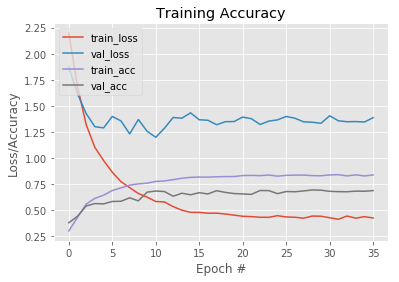

In [268]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

Постройте confusion_matrix (используйте sklearn) на тестовой выборке (test) и посчитайте долю правильных ответов(test)

Доля верных ответов на всем тесте: 0.63


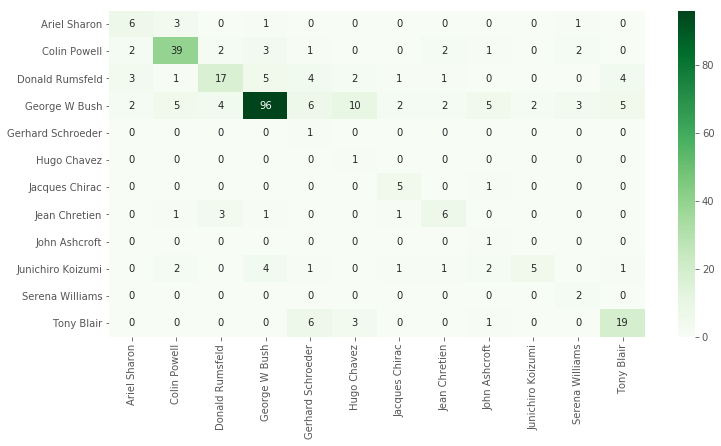

In [269]:
y_pred = model_conv.predict(x_test.reshape(x_test.shape[0], input_shape[0], input_shape[1], 1)).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
confusionmatrix = confusion_matrix(y_pred, y_true)

accuracy = accuracy_score(y_pred, y_true)
print('Доля верных ответов на всем тесте: %.2f' % accuracy)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Кажется, что стало лучше, но постройте график зависимости доли правильных ответов от эпохи на обучении и валидации. Какие выводы можно сделать?  

### Ваши ответы здесь

## Aугментация дынных (40%)
Вспомним, что для борьбы с переобучением, нам может помочь Aугментация, для этого мы будем использовать стандартные возможности Keras. Загляните в [доку](https://keras.io/preprocessing/image/) или в эту [статью](https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085) 

Вы можете использовать любые аугментации

In [352]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rotation_range = 15, 
               width_shift_range = 0.1, 
               height_shift_range = 0.1, 
               shear_range = 0.01,
               zoom_range = [0.9, 1.25])

dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rotation_range = 5, 
               width_shift_range = 0.1, 
               height_shift_range = 0.1)


image_gen = ImageDataGenerator(**dg_args)
@threadsafe_generator
def create_aug_gen(in_gen, seed=None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        g_x = image_gen.flow(255*in_x, 
                             batch_size=in_x.shape[0])

        yield next(g_x)/255., in_y

(50, 50, 37, 1) (50, 12)


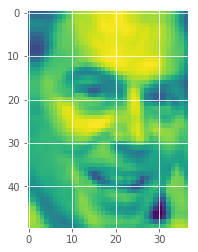

In [378]:
valid_x, valid_y = next(create_aug_gen(make_image_gen_cat_conv((x_test, y_test_cat))))
print(valid_x.shape, valid_y.shape)

test = valid_x[0,:,:,0]
plt.imshow(test)

In [364]:
weight_path='easy_conv.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=7)



callbacks_list = [checkpoint, reduceLROnPlat, early]

In [365]:
model_conv = small_conv_net.build(classes=num_classes, finalAct="softmax")
opt = Adam(lr=1e-3)
model_conv.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model_conv)

In [379]:
aug_gen = create_aug_gen(make_image_gen_cat_conv((x_train, y_train_cat)))
gen_valid_cat = make_image_gen_cat_conv((x_val, y_val_cat))

history = model_conv.fit_generator(aug_gen,
                                   steps_per_epoch=300,
                                   validation_data=gen_valid_cat,
                                   validation_steps=50,
                                   epochs=epochs,
                                   callbacks=callbacks_list,
                                   workers=16,
                                   verbose=1)

Epoch 1/100
300/300 [==============================] - 40s 134ms/step - loss: 2.1693 - acc: 0.3324 - val_loss: 2.0246 - val_acc: 0.4008

Epoch 00001: val_acc improved from 0.36300 to 0.40080, saving model to easy_conv.h5
Epoch 2/100
300/300 [==============================] - 40s 135ms/step - loss: 2.1696 - acc: 0.3323 - val_loss: 2.0258 - val_acc: 0.4000

Epoch 00002: val_acc did not improve from 0.40080
Epoch 3/100
300/300 [==============================] - 42s 140ms/step - loss: 2.1702 - acc: 0.3324 - val_loss: 2.0241 - val_acc: 0.4012

Epoch 00003: val_acc improved from 0.40080 to 0.40120, saving model to easy_conv.h5
Epoch 4/100
300/300 [==============================] - 43s 144ms/step - loss: 2.1693 - acc: 0.3323 - val_loss: 2.0247 - val_acc: 0.4000

Epoch 00004: val_acc did not improve from 0.40120
Epoch 5/100
300/300 [==============================] - 40s 133ms/step - loss: 2.1697 - acc: 0.3322 - val_loss: 2.0235 - val_acc: 0.4008

Epoch 00005: val_acc did not improve from 0.401

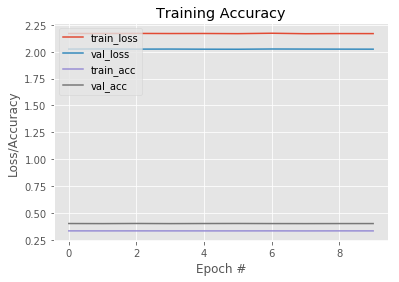

In [380]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

Доля верных ответов на всем тесте: 0.35


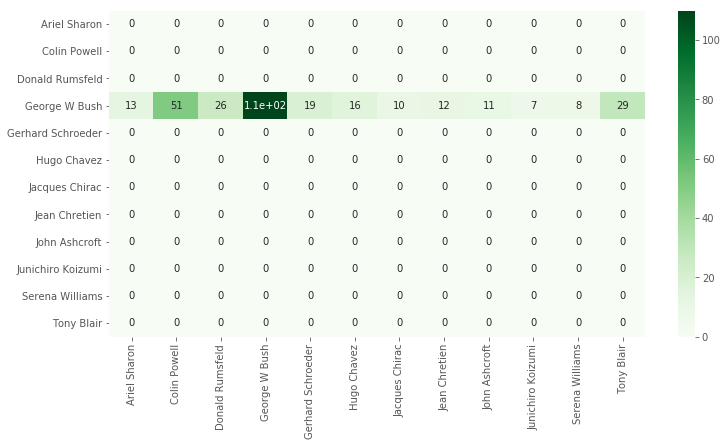

In [381]:
y_pred = model_conv.predict(x_test.reshape(x_test.shape[0], input_shape[0], input_shape[1], 1)).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
confusionmatrix = confusion_matrix(y_pred, y_true)

accuracy = accuracy_score(y_pred, y_true)
print('Доля верных ответов на всем тесте: %.2f' % accuracy)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Посмотрите долю правильных ответов на тестовой выборке и постройте график зависимости от эпох для обучения и валидации
Ответьте на вопросы и объясните свой ответ: 
- Удалось ли Вам победить переобучение? 
- Будет ли полезна аугментация horizontal_flip?

### Ваши ответы здесь

## Дополнительное задание (дополнительные +30%) 
Обучите такую нейронную сеть, чтобы на тестовой выборке достичь доли правильных ответов больше 92%

In [ ]:
# Ваш код здесь